In [5]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Required libraries imported successfully!


In [6]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

# 1. Chargement et prise en main des données

In [7]:
def load_corpus(file_path: str) -> Dict[str, Dict]:
    """
    Load corpus data from a JSONL file.
    Returns a dictionary mapping document IDs to their associated metadata.
    """
    corpus = {}
    
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():  # skip empty lines
                doc = json.loads(line)
                doc_id = doc.get("_id")
                if doc_id is not None:
                    corpus[doc_id] = doc
                    
    return corpus


def load_queries(file_path: str) -> Dict[str, Dict]:
    """
    Load query data from a JSONL file.
    Returns a dictionary mapping query IDs to query metadata.
    """
    queries = {}
    
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                q = json.loads(line)
                q_id = q.get("_id")
                if q_id is not None:
                    queries[q_id] = q
                    
    return queries


def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:
    """
    Load relevance judgments from a TSV file.
    Returns a dictionary:
        { query_id : { candidate_id : relevance_score } }
    """
    qrels = {}
    
    with open(file_path, "r", encoding="utf-8") as f:
        next(f) #On saute l'en-tête
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 3:
                continue  
            
            q_id, c_id, score = parts
            score = int(score)

            if q_id not in qrels:
                qrels[q_id] = {}
            qrels[q_id][c_id] = score
    
    return qrels

# Load the dataset
print("Loading dataset...")
corpus = load_corpus('dataset_BE2/corpus.jsonl')
queries = load_queries('dataset_BE2/queries.jsonl')
qrels_valid = load_qrels('dataset_BE2/valid.tsv')


print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loading dataset...
Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 700 queries (dataset)


# 2 - Exploration des données et premier encodage

In [14]:
nb_docs = len(corpus)
nb_queries = len(queries)
nb_pairs = sum(len(docs) for docs in qrels_valid.values()) #on prend chaque dictionnaire de documents pour chaque requête et on somme
proportions = []
for qid, docs in qrels_valid.items(): ##[..].items contient une ligne par requête avec id de chaque document et score
    total_docs = len(docs)
    if total_docs == 0:
        continue  
    num_positifs = sum(1 for score in docs.values() if score == 1)
    proportion = num_positifs / total_docs
    proportions.append(proportion)

moyenne_proportion = sum(proportions) / len(proportions)

print(f"Taille du corpus : {nb_docs} documents")
print(f"Nombre de requêtes : {nb_queries}")
print(f"Nombre total de paires requête/document : {nb_pairs}")
print(f"Proportion d'articles pertinents par requète : {round(moyenne_proportion*100)}%")


Taille du corpus : 25657 documents
Nombre de requêtes : 1000
Nombre total de paires requête/document : 20950
Proportion d'articles pertinents par requète : 16%


In [15]:
def show_example_query(corpus, queries, qrels, q_id=None):

    if q_id is None:
        q_id = next(iter(queries))  # prend la première requete

    query = queries[q_id]

    print("Requête")
    print("ID :", q_id)
    print("Titre :", query.get("text"))
    print()

    # On sépare les positifs des négatifs
    candidates = qrels[q_id]
    positives = [c for c, s in candidates.items() if s == 1]
    negatives = [c for c, s in candidates.items() if s == 0]

    # On affiche des candidats
    print("Candidats positifs")
    for c_id in positives[:3]:
        print("-", corpus[c_id]["title"])
    print()

    print("Candidats négatifs")
    for c_id in negatives[:3]:
        print("-", corpus[c_id]["title"])

show_example_query(corpus, queries, qrels_valid)


Requête
ID : 78495383450e02c5fe817e408726134b3084905d
Titre : A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect

Candidats positifs
- A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
- A modified particle swarm optimizer
- Identification and control of dynamic systems using recurrent fuzzy neural networks

Candidats négatifs
- A data mining approach for location prediction in mobile environments
- Treatment-Response Models for Counterfactual Reasoning with Continuous-time, Continuous-valued Interventions
- Dissecting and Reassembling Color Correction Algorithms for Image Stitching


### Premier encodage des données

In [18]:
def extract_titles(corpus, queries):
    #Retourne une liste des titres du corpus + queries ainsi que les IDs correspondants
    texts=[]
    ids=[]

    #corpus
    for doc_id, doc in corpus.items():
        title = doc.get("title", "").strip()
        texts.append(title)
        ids.append(doc_id)
    
    #requêtes
    for q_id, query in queries.items():
        title=query.get("text")
        texts.append(title.strip())
        ids.append(q_id)

    return texts, ids

from sklearn.feature_extraction.text import CountVectorizer

def build_document_term_matrix(texts):
    vectorizer= CountVectorizer()
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

texts, ids = extract_titles(corpus, queries)
X, vectorizer = build_document_term_matrix(texts)
print(X.shape)
print("Longueur du vocabulaire :", len(vectorizer.get_feature_names_out()))

# Exemple : affichage des 3 termes les plus fréquents du 3è document (dans son titre)
features = vectorizer.get_feature_names_out()
example_vec=X[2]
display(print_feats(example_vec,features, top_n=3))

(26657, 20392)
Longueur du vocabulaire : 20392


,word,value
0,fuzzy,2
1,and,1
2,bases,1


### Distribution des mots les plus fréquemment employés dans le corpus

,word,value
0,of,9190
1,and,8829
2,for,8430
3,in,5297
4,the,5024
5,with,2757
6,on,2672
7,based,2660
8,using,2602
9,to,2343


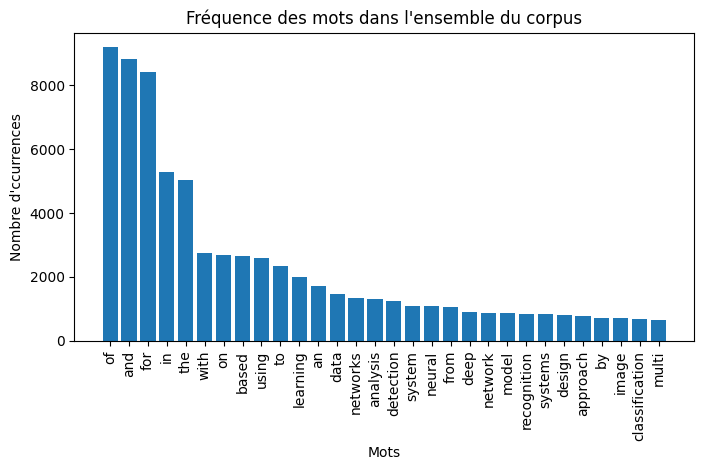

In [33]:
from scipy.sparse import csr_matrix

term_frequencies = np.asarray(X.sum(axis=0)).ravel()
freq_vector = csr_matrix(term_frequencies)
features = vectorizer.get_feature_names_out()

#Affichage des 30 mots les plus fréquents
top_words=print_feats(freq_vector,features, top_n=30)
display(top_words)

#Affichage graphique
plt.figure(figsize=(8,4))
plt.bar(top_words["word"], top_words["value"])
plt.xticks(rotation=90)
plt.xlabel("Mots")
plt.ylabel("Nombre d'ccurrences")
plt.title("Fréquence des mots dans l'ensemble du corpus")
plt.show()

# 3. Comparaison de documents et premier moteur de recherche

### Comparaison de documents

D'abord, sans prise en compte des résumés, seulement des titres.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

def compare_docs(i,j,X,ids,corpus):
    v1=X[i]
    v2=X[j]
    sim = cosine_similarity(v1,v2)[0,0]

    print(f"Cosine similarity entre {ids[i]} et {ids[j]} : {sim:.4f}\n")
    print("Doc1 : ", corpus.get(ids[i], {}).get("title", ""))
    print("Doc2 : ", corpus.get(ids[j], {}).get("title", ""))

    #Affichage des mots en commun :
    common = v1.multiply(v2)
    display(print_feats(common,features, top_n=20))

compare_docs(10, 7, X, ids, corpus)

Cosine similarity entre 9f234867df1f335a76ea07933e4ae1bd34eeb48a et 1ae0ac5e13134df7a0d670fc08c2b404f1e3803c : 0.1361

Doc1 :  Automatic Machine Translation Evaluation: A Qualitative Approach
Doc2 :  A data mining approach for location prediction in mobile environments


,word,value
0,approach,1


En ne prenant en compte que les titres, il est logiquement difficile de trouver des similarités entre 2 documents différents. 